In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary

from modules.deepglobe_dataset import DeepGlobeDataset
from modules.crop4 import CropInto4Transform
from modules.collate_function import collate_fn 

import mlflow
import mlflow.pytorch

# Road Segmentation

## Data Handling

### Functions that could be used for both datasets

In [3]:
def display_proportions(meta):
    train_portion = meta.groupby('split').size()['train']/len(meta)
    val_portion = meta.groupby('split').size()['val']/len(meta)
    test_portion = meta.groupby('split').size()['test']/len(meta)
    
    print(f'Train portion: {train_portion}')
    print(f'Validation portion: {val_portion}')
    print(f'Test portion: {test_portion}')

In [4]:
def reassign_split(meta, val_portion=0.1, test_portion = 0.1):
    meta.split = 'train'
    total_len = len(meta)
    test_start_idx = total_len - round(total_len * test_portion)
    val_start_idx = total_len - round(total_len * (test_portion + val_portion))
    
    
    meta.loc[test_start_idx:, 'split'] = 'test'
    meta.loc[val_start_idx:test_start_idx-1, 'split'] = 'val'
    
    return meta

### Deepglobe dataset

#### Reading and fixing splits

In [5]:
root_deep='data/deepglobe/'

In [6]:
deep_meta = pd.read_csv('data/deepglobe/metadata.csv')
deep_meta = deep_meta[deep_meta.split == 'train']
deep_meta = reassign_split(deep_meta)
deep_meta

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png
...,...,...,...,...
6221,999431,test,train/999431_sat.jpg,train/999431_mask.png
6222,999531,test,train/999531_sat.jpg,train/999531_mask.png
6223,999667,test,train/999667_sat.jpg,train/999667_mask.png
6224,999764,test,train/999764_sat.jpg,train/999764_mask.png


In [7]:
display_proportions(deep_meta)

Train portion: 0.8000321233536781
Validation portion: 0.09990362993896562
Test portion: 0.10006424670735625


#### Testing data

In [8]:
image_test = Image.open(os.path.join(root_deep, deep_meta.iloc[15].sat_image_path))
mask_test = np.array(Image.open(os.path.join(root_deep, deep_meta.iloc[15].mask_path)).convert('L'))

In [9]:
np.unique(mask_test)

array([  0, 255], dtype=uint8)

In [10]:
mask_test = Image.open(os.path.join(root_deep, deep_meta.iloc[15].mask_path)).convert('L')

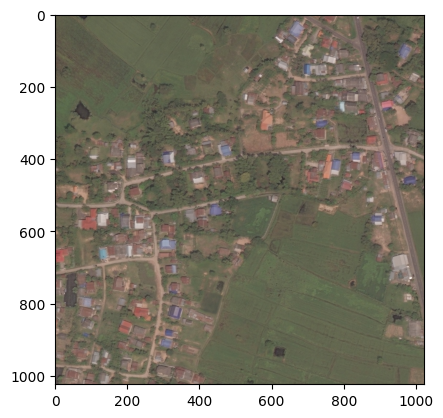

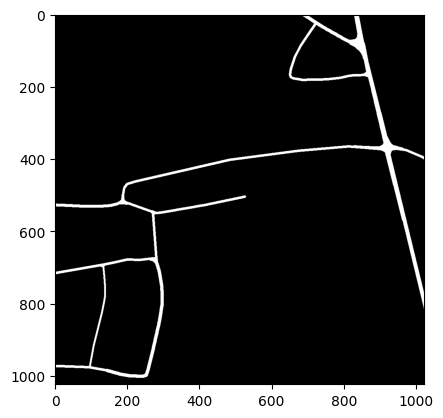

In [11]:
plt.imshow(image_test)
plt.show()
plt.imshow(mask_test, cmap='gray')
plt.show()

## Efficient data loading

### PyTorch Dataset + Transformer

*Files transfered to '/modules'*

In [12]:
image_transform = transforms.Compose([
    CropInto4Transform(size=512)
])

In [13]:
torch.multiprocessing.set_start_method('spawn')

In [14]:
testing_md = deep_meta.iloc[0:4].reset_index(drop=True)

testing_ds = DeepGlobeDataset(testing_md, transform=image_transform)

In [15]:
train_metadata = deep_meta[deep_meta.split == 'train'].reset_index(drop=True)
val_metadata = deep_meta[deep_meta.split == 'val'].reset_index(drop=True)
test_metadata = deep_meta[deep_meta.split == 'test'].reset_index(drop=True)

train_ds = DeepGlobeDataset(train_metadata, transform=image_transform)
val_ds = DeepGlobeDataset(val_metadata, transform=image_transform)
test_ds = DeepGlobeDataset(test_metadata, transform=image_transform)

In [16]:
print(f'Image shape: {train_ds[0][0].shape}')
print(f'Mask shape: {train_ds[0][1].shape}')

Image shape: torch.Size([4, 3, 512, 512])
Mask shape: torch.Size([4, 1, 512, 512])


### Pytorch DataLoader

*Collate function transfered to '/modules'*

In [17]:
BATCH_SIZE = 1
NUM_WORKERS = 3
PIN_MEMORY = True
PREFETCH_FACTOR = 3

In [18]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, prefetch_factor=PREFETCH_FACTOR)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, prefetch_factor=PREFETCH_FACTOR)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, prefetch_factor=PREFETCH_FACTOR)

testing_dl = DataLoader(testing_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, prefetch_factor=PREFETCH_FACTOR)

In [19]:
for batch in testing_dl:
    images, masks = batch
    print(images.shape)
    print(masks.shape)
    break

torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512])


## Model Evaluation metrics

### IoU

In [20]:
def check_iou(model, loader, threshold=0.5):
    iou_scores = np.array([])
    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            preds = model(images)
            preds = torch.sigmoid(preds)
            preds = (preds > threshold).float()
            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_scores = np.append(iou_scores, iou.cpu())
    return iou_scores.mean()

In [21]:
def calculate_iou(preds, masks, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

## Models

In [22]:
DEVICE = torch.device('cuda')

### U-Net

#### Architecture

In [23]:
# Credit to https://github.com/aladdinpersson/Machine-Learning-Collection

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [24]:
class UNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]
    ):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(in_channels=features[0], out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections=[]

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [25]:
torch.cuda.empty_cache()
unet = UNet().to(DEVICE)

#### Summary

In [26]:
summary(unet, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

#### Training

In [27]:
LR = 1e-4
LOSS = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.Adam(unet.parameters(), lr=LR)
SCALER = torch.amp.GradScaler()
N_EPOCHS = 6

In [28]:
def save_checkpoint(model, epoch, checkpoint_dir):
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt'))

In [29]:
def train(model, train_loader, val_loader, loss_fn, optimizer, scaler, n_epochs, checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    train_loss_values = np.array([])
    val_loss_values = np.array([])

    train_iou_scores = np.array([])
    val_iou_scores = np.array([])
    
    def train_epoch(model, train_loader, loss_fn, optimizer, scaler):
        model.train()
        loop = tqdm(train_loader)
        running_loss = 0.0

        for batch_idx, (images, masks) in enumerate(loop):
            images = images.half().to(DEVICE)
            masks = masks.half().to(DEVICE)

            with torch.amp.autocast('cuda'):
                predictions = model(images).half()
                loss = loss_fn(predictions, masks)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        return running_loss / len(train_loader), check_iou(model, train_loader)

    def validate_epoch(model, val_loader, loss_fn):
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.half().to(DEVICE)
                masks = masks.half().to(DEVICE)

                with torch.amp.autocast('cuda'):
                    predictions = model(images).half()
                    loss = loss_fn(predictions, masks)
                
                running_loss += loss.item()

        return running_loss / len(val_loader), check_iou(model, val_loader)

    mlflow.set_experiment('UNet-Segmentation')
    for epoch in range(n_epochs):
        train_loss, train_iou = train_epoch(model, train_loader, loss_fn, optimizer, scaler)
        val_loss, val_iou = validate_epoch(model, val_loader, loss_fn)

        train_loss_values = np.append(train_loss_values, train_loss)
        val_loss_values = np.append(val_loss_values, val_loss)

        train_iou_scores = np.append(train_iou_scores, train_iou)
        val_iou_scores = np.append(val_iou_scores, val_iou)

        save_checkpoint(model, epoch, checkpoint_dir)

        print(f"Epoch {epoch+1}/{n_epochs}\n Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}\n Training IoU: {train_iou}, Validation IoU: {val_iou}")

    mlflow.log_metric('train_loss', train_loss_values[-1], step=epoch)
    mlflow.log_metric('val_loss', val_loss_values[-1], step=epoch)
    mlflow.log_metric('train_iou', train_iou_scores[-1], step=epoch)
    mlflow.log_metric('val_iou', val_iou_scores[-1], step=epoch)
    mlflow.log_metric('lr', optimizer.param_groups[0]['lr'], step=epoch)

    mlflow.end_run()

    return model, (train_loss_values, val_loss_values), (train_iou_scores, val_iou_scores)

In [30]:
unet, loss_history, iou_history = train(unet, train_dl, val_dl, LOSS, OPTIMIZER, SCALER, N_EPOCHS)

  1%|▊                                                                | 59/4981 [19:21<26:55:03, 19.69s/it, loss=0.339]


KeyboardInterrupt: 

In [ ]:
torch.save(unet, 'unet_model.pth')

In [31]:
torch.cuda.empty_cache()